# Analysis: Explanation Stability During Training

This notebook loads all experimental results and evaluates the temporal stability of 
saliency maps and integrated gradients over training. We compute cosine similarity, 
Spearman rank correlation, and temporal variance, and visualize these metrics to study 
when explanations stabilize and how stability depends on dataset, model size, and learning rate.


In [191]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")


# Load all saved experiment runs (.pt files) from disk into a list of dictionaries.
def load_results(results_dir="results"):
    runs = []
    for fname in os.listdir(results_dir):
        if fname.endswith(".pt"):
            data = torch.load(os.path.join(results_dir, fname))
            runs.append(data)
    return runs


runs = load_results("results")
print(f"Loaded {len(runs)} runs")


Loaded 160 runs


## Metrics

In [192]:
def cosine_stability(E_t, E_t1):
    a = E_t.flatten()
    b = E_t1.flatten()
    return torch.nn.functional.cosine_similarity(a, b, dim=0).item()

In [193]:
def rank_stability(E_t, E_t1):
    a = torch.abs(E_t).flatten().cpu().numpy()
    b = torch.abs(E_t1).flatten().cpu().numpy()
    return spearmanr(a, b).correlation

In [194]:
def explanation_variance_per_run(explanations):
    """
    explanations: list of tensors [epochs, N, C, H, W]
    returns: scalar
    """
    E = torch.stack(explanations)   # [T, N, C, H, W]
    var_over_time = torch.var(E, dim=0)  # variance over epochs
    return var_over_time.mean().item()


In [195]:
def cosine_to_final(explanations):
    """
    explanations: list of tensors [epochs, N, C, H, W]
    returns: array of length epochs
    """
    E_final = explanations[-1]
    epochs = len(explanations)

    vals = []
    for t in range(epochs):
        cos_epoch = []
        for i in range(explanations[t].shape[0]):
            cos_epoch.append(
                cosine_stability(
                    explanations[t][i], E_final[i]
                )
            )
        vals.append(np.mean(cos_epoch))
    return np.array(vals)


## Preparation

In [196]:
# Compute stability metrics over epochs (cosine, rank, convergence to final, variance).
def compute_timeseries(run):
    explanations = run["explanations"]
    epochs = len(explanations)

    cosine_vals = []
    rank_vals = []

    for t in range(epochs - 1):
        cos_epoch = []
        rank_epoch = []

        for i in range(explanations[t].shape[0]):
            cos_epoch.append(
                cosine_stability(
                    explanations[t][i], explanations[t+1][i]
                )
            )
            rank_epoch.append(
                rank_stability(
                    explanations[t][i], explanations[t+1][i]
                )
            )

        cosine_vals.append(np.mean(cos_epoch))
        rank_vals.append(np.mean(rank_epoch))

    return {
        "accuracy": np.array(run["accuracy"]),
        "cosine": np.array(cosine_vals),
        "rank": np.array(rank_vals),
        "cosine_to_final": cosine_to_final(explanations),
        "variance": explanation_variance_per_run(explanations),
    }


In [197]:
# Select runs matching a specific dataset, model, learning rate, and explanation method.
def filter_runs(
    runs,
    dataset,
    model,
    lr,
    expl_method
):
    return [
        r for r in runs
        if r["dataset"] == dataset
        and r["model"] == model
        and r["learning_rate"] == lr
        and r["explain_method"] == expl_method
    ]


In [198]:
# Aggregate timeseries metrics over multiple random seed.
def aggregate_over_seeds(runs):
    all_acc, all_cos, all_rank, all_var = [], [], [], []

    for r in runs:
        ts = compute_timeseries(r)

        acc = np.array(ts["accuracy"]).squeeze()
        cos = np.array(ts["cosine"]).squeeze()
        rank = np.array(ts["rank"]).squeeze()

        all_acc.append(acc)
        all_cos.append(cos)
        all_rank.append(rank)

        all_var.append(
            explanation_variance_per_run(r["explanations"])
        )

    all_acc = np.stack(all_acc)
    all_cos = np.stack(all_cos)
    all_rank = np.stack(all_rank)
    all_var = np.array(all_var)

    return {
        "acc_mean": all_acc.mean(axis=0),
        "acc_std": all_acc.std(axis=0),

        "cos_mean": all_cos.mean(axis=0),
        "cos_std": all_cos.std(axis=0),

        "rank_mean": all_rank.mean(axis=0),
        "rank_std": all_rank.std(axis=0),

        "var_mean": all_var.mean(),
        "var_std": all_var.std(),
    }


In [199]:
def aggregate_cosine_to_final(runs):
    all_vals = []
    for r in runs:
        ts = compute_timeseries(r)
        all_vals.append(ts["cosine_to_final"])

    min_len = min(len(v) for v in all_vals)
    all_vals = np.stack([v[:min_len] for v in all_vals])

    return {
        "mean": all_vals.mean(axis=0),
        "std": all_vals.std(axis=0),
    }

In [200]:
def safe_aggregate(runs, name=""):
    if len(runs) == 0:
        raise ValueError(f"No runs found for {name}")
    return aggregate_over_seeds(runs)


In [201]:
def extract_final_metrics(run):
    """
    Extract final epoch metrics from a single run
    """
    final_accuracy = run["accuracy"][-1]
    
    explanations = run["explanations"]
    if len(explanations) < 2:
        final_cosine = None
    else:
        cos_vals = []
        for i in range(explanations[-1].shape[0]):
            cos_vals.append(
                cosine_stability(explanations[-2][i], explanations[-1][i])
            )
        final_cosine = np.mean(cos_vals)
    
    variance = explanation_variance_per_run(explanations)
    
    return {
        "final_accuracy": final_accuracy,
        "final_cosine": final_cosine,
        "variance": variance,
        "dataset": run["dataset"],
        "model": run["model"],
        "lr": run["learning_rate"],
        "method": run["explain_method"]
    }


In [202]:
# Average over learning rates
def average_metrics_over_lr(runs):

    # Extract all metrics
    all_metrics = []
    for run in runs:
        metrics = extract_final_metrics(run)
        if metrics["final_cosine"] is not None:
            all_metrics.append(metrics)
    
    # Group by (dataset, model, method)
    groups = {}
    for m in all_metrics:
        key = (m["dataset"], m["model"], m["method"])
        if key not in groups:
            groups[key] = []
        groups[key].append(m)
    
    # Average each group
    averaged = []
    for key, group in groups.items():
        dataset, model, method = key
        
        avg_metrics = {
            "dataset": dataset,
            "model": model,
            "method": method,
            "final_accuracy": np.mean([m["final_accuracy"] for m in group]),
            "final_cosine": np.mean([m["final_cosine"] for m in group]),
            "variance": np.mean([m["variance"] for m in group])
        }
        averaged.append(avg_metrics)
    
    return averaged

# Plots

In [203]:
plt.rcParams.update({
    "font.size": 14,            
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.titlesize": 17,
    "lines.linewidth": 2,
})

### Stability: Cosine similarity and Spearman Rank Corelation

In [204]:
def plot_cosine_vs_epoch(vanilla, integrated, title, save_path=None):
    epochs = np.arange(len(vanilla["cos_mean"]))

    plt.figure(figsize=(7, 5))
    v_mean = vanilla["cos_mean"]
    v_std = vanilla["cos_std"]
    v_lower = np.clip(v_mean - v_std, 0.0, 1.0)
    v_upper = np.clip(v_mean + v_std, 0.0, 1.0)

    plt.plot(epochs, v_mean, label="Saliency")
    plt.fill_between(epochs, v_lower, v_upper, alpha=0.2)

    i_mean = integrated["cos_mean"]
    i_std = integrated["cos_std"]
    i_lower = np.clip(i_mean - i_std, 0.0, 1.0)
    i_upper = np.clip(i_mean + i_std, 0.0, 1.0)

    plt.plot(epochs, i_mean, label="Integrated")
    plt.fill_between(epochs, i_lower, i_upper, alpha=0.2)

    plt.xlabel("Epoch")
    plt.ylabel("Cosine Similarity (t, t+1)")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [205]:
def plot_rank_vs_epoch(vanilla, integrated, title, save_path=None):
    epochs = np.arange(len(vanilla["rank_mean"]))

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, vanilla["rank_mean"], label="Saliency")
    plt.plot(epochs, integrated["rank_mean"], label="Integrated")

    plt.xlabel("Epoch")
    plt.ylabel("Spearman Rank Correlation")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [206]:
def run_base_stability_plots(
    runs,
    dataset,
    model,
    lr,
    save_dir=None
):
    """
    Runs Plot (Cosine similarity) and Plot(Rank) for a given configuration.
    """

    vanilla_runs = filter_runs(
        runs, dataset, model, lr, "vanilla"
    )
    integrated_runs = filter_runs(
        runs, dataset, model, lr, "integrated"
    )

    vanilla_agg = safe_aggregate(
        vanilla_runs,
        f"{dataset}-{model}-vanilla"
    )
    integrated_agg = safe_aggregate(
        integrated_runs,
        f"{dataset}-{model}-integrated"
    )

    title_base = (
        f"{dataset.upper()} | {model.capitalize()} CNN | LR={lr}"
    )

    # Plot 1: Cosine
    plot_cosine_vs_epoch(
        vanilla_agg,
        integrated_agg,
        title=f"Cosine Stability vs Epoch ({title_base})",
        save_path=(
            f"{save_dir}/cosine_{dataset}_{model}_lr{lr}.png"
            if save_dir else None
        )
    )

    # Plot 2: Rank
    plot_rank_vs_epoch(
        vanilla_agg,
        integrated_agg,
        title=f"Rank Stability vs Epoch ({title_base})",
        save_path=(
            f"{save_dir}/rank_{dataset}_{model}_lr{lr}.png"
            if save_dir else None
        )
    )


#### MNIST; SMALL CNN

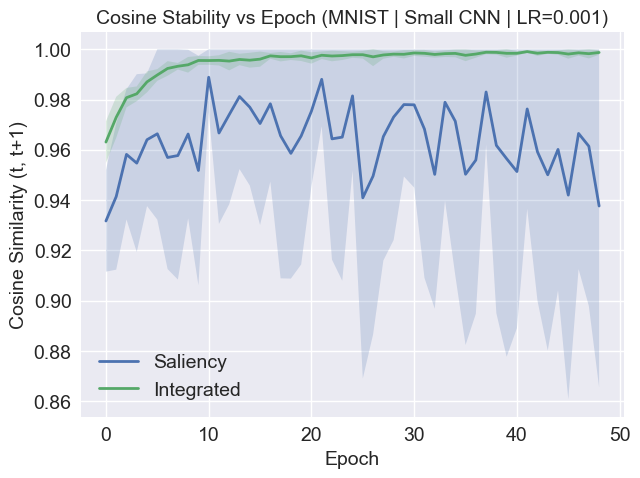

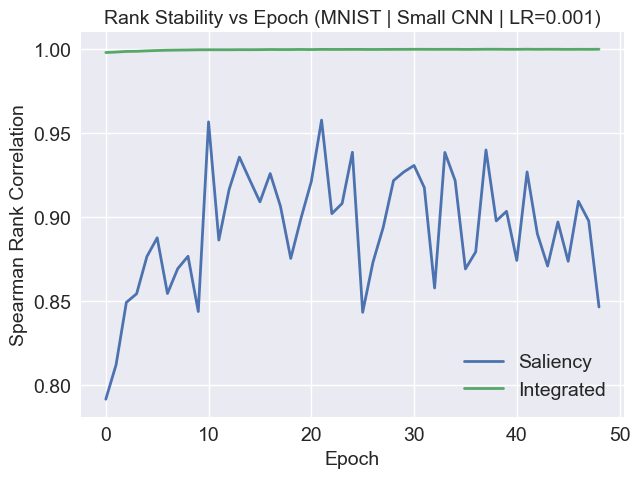

In [207]:
run_base_stability_plots(
    runs,
    dataset="mnist",
    model="small",
    lr=0.001,
    save_dir="plots"
)

### MNIST; Deep CNN

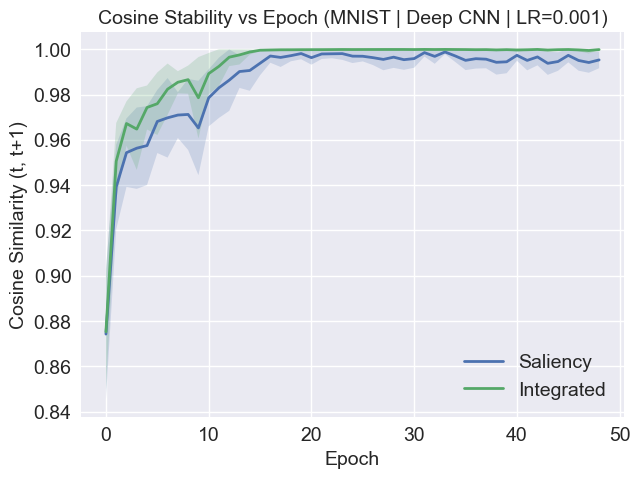

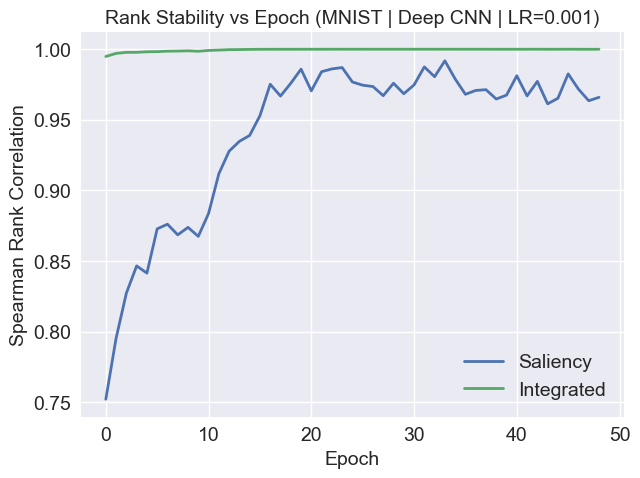

In [208]:
run_base_stability_plots(
    runs,
    dataset="mnist",
    model="deep",
    lr=0.001
)

### CIFAR; Small CNN

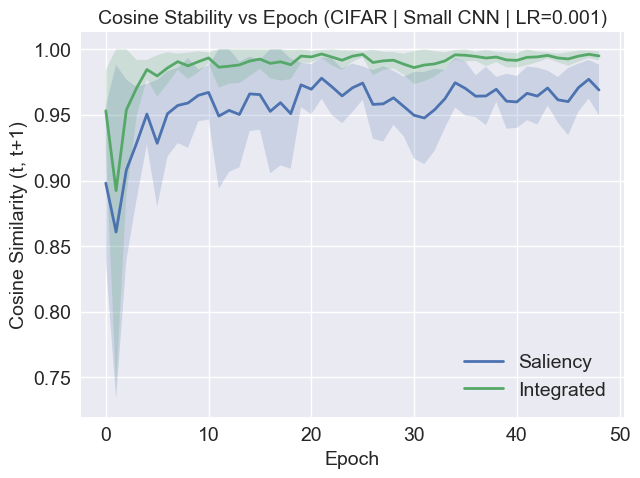

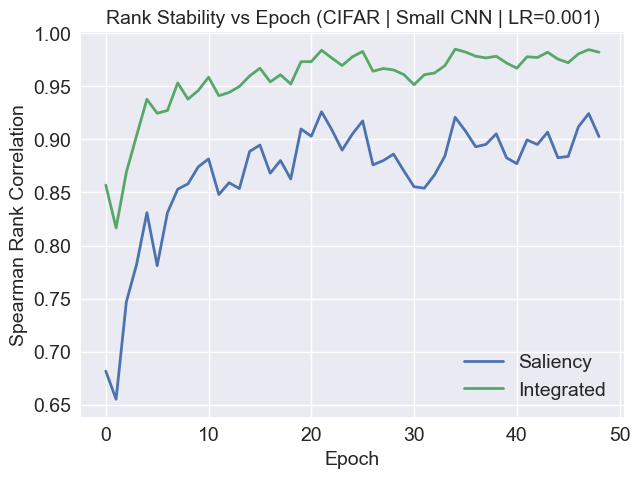

In [209]:
run_base_stability_plots(
    runs,
    dataset="cifar",
    model="small",
    lr=0.001,
    save_dir="plots"
)

### CIFAR; Deep CNN

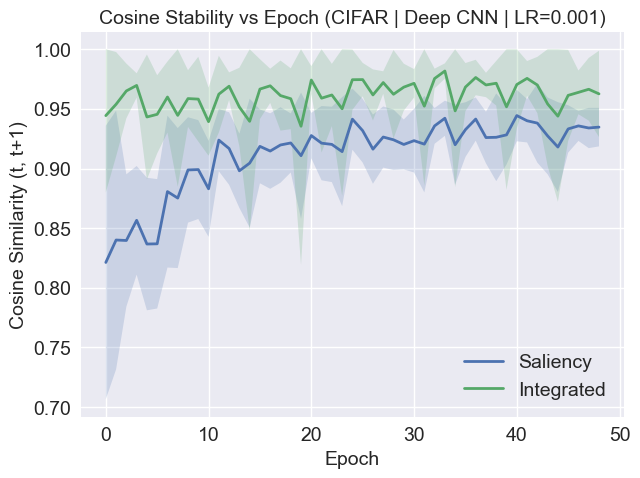

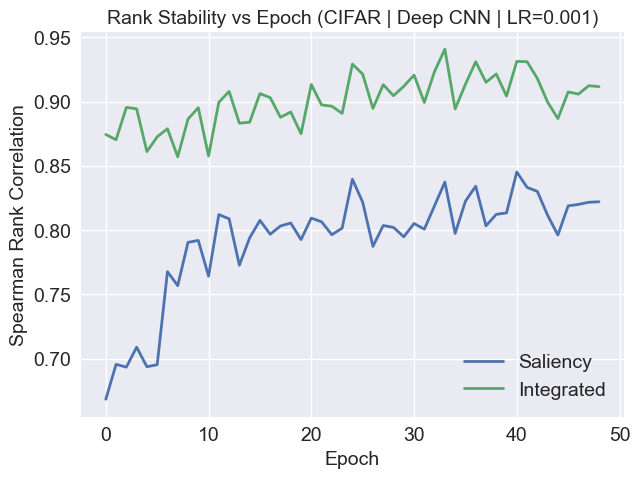

In [210]:
run_base_stability_plots(
    runs,
    dataset="cifar",
    model="deep",
    lr=0.001,
    save_dir="plots"
)

## Convergence

In [211]:
def plot_cosine_to_final(vanilla, integrated, title, save_path=None):
    epochs = np.arange(len(vanilla["mean"]))

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, vanilla["mean"], label="Saliency")
    plt.plot(epochs, integrated["mean"], label="Integrated")

    plt.xlabel("Epoch")
    plt.ylabel("Cosine Similarity to Final Explanation")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [212]:
def run_convergence_plot(
    runs,
    dataset,
    model,
    lr,
    save_dir=None
):
    """
    Cosine similarity to final explanation
    for a given dataset / model / learning rate.
    """

    #Filter runs
    vanilla_runs = filter_runs(
        runs, dataset, model, lr, "vanilla"
    )
    integrated_runs = filter_runs(
        runs, dataset, model, lr, "integrated"
    )

    #Aggregate
    vanilla_conv = aggregate_cosine_to_final(vanilla_runs)
    integrated_conv = aggregate_cosine_to_final(integrated_runs)

    title = (
        f"Explanation Convergence to Final Epoch "
        f"({dataset.upper()} | {model.capitalize()} CNN | LR={lr})"
    )

    plot_cosine_to_final(
        vanilla_conv,
        integrated_conv,
        title=title,
        save_path=(
            f"{save_dir}/cosine_to_final_{dataset}_{model}_lr{lr}.png"
            if save_dir else None
        )
    )


### MNIST; Small CNN

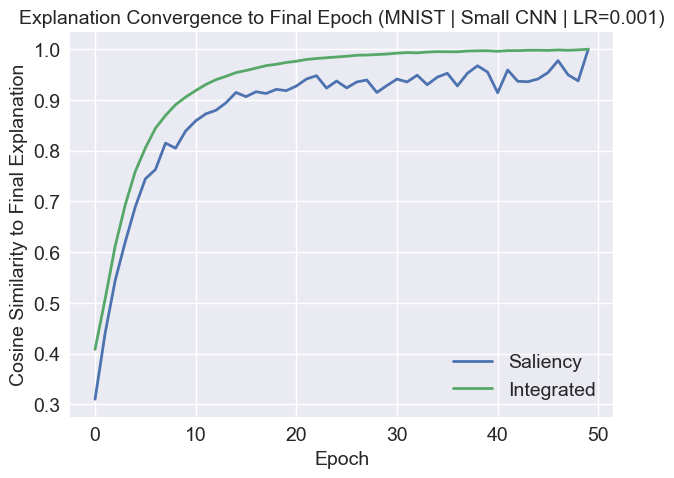

In [213]:
run_convergence_plot(
    runs,
    dataset="mnist",
    model="small",
    lr=0.001,
    save_dir="plots"
)

### CIFAR; Deep CNN

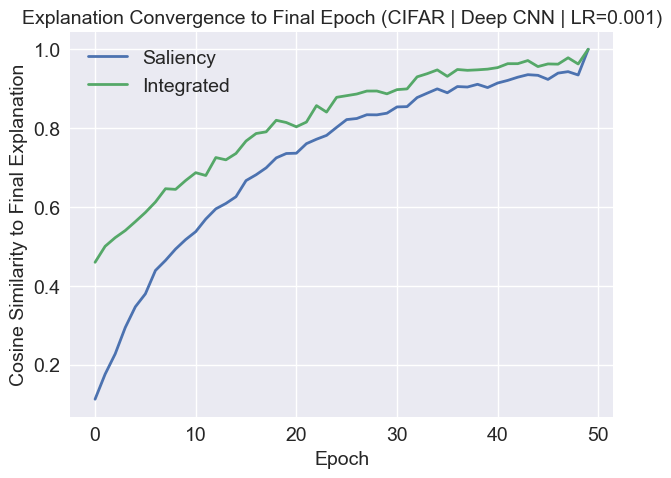

In [214]:
run_convergence_plot(
    runs,
    dataset="cifar",
    model="deep",
    lr=0.001,
    save_dir="plots"
)

## Predictive Convergence vs. Explanation Convergence

In [215]:
def plot_accuracy_and_convergence(vanilla_agg, integrated_agg, vanilla_conv, integrated_conv, 
                                   dataset, model, lr, save_path=None):
    """
    Plot accuracy and cosine similarity to final explanation on the same figure with dual y-axes
    """
    fig, ax1 = plt.subplots(figsize=(8, 5))
    
    # First y-axis: Accuracy (only one line - should be same for both methods)
    epochs_acc = np.arange(len(vanilla_agg["acc_mean"]))
    ax1.set_xlabel("Epoch", fontsize=14)
    ax1.set_ylabel("Accuracy", fontsize=14, color='tab:blue')
    
    # Plot accuracy (use vanilla, but integrated should be identical)
    line1 = ax1.plot(epochs_acc, vanilla_agg["acc_mean"], 
                     color='steelblue', linestyle='-', linewidth=2,
                     label="Model Accuracy")
    
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)
    
    # Second y-axis: Cosine Similarity to Final
    ax2 = ax1.twinx()
    ax2.set_ylabel("Cosine Similarity to Final Explanation", fontsize=12, color='tab:orange')
    
    epochs_cos = np.arange(len(vanilla_conv["mean"]))
    line2 = ax2.plot(epochs_cos, vanilla_conv["mean"], 
                     color='coral', linestyle='-', linewidth=2,
                     label="Cosine to Final - Saliency")
    line3 = ax2.plot(epochs_cos, integrated_conv["mean"], 
                     color='orangered', linestyle='--', linewidth=2,
                     label="Cosine to Final - Integrated")
    
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    # Combine legends
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right', fontsize=14, framealpha=0.9)
    
    plt.title(f"Accuracy & Convergence vs Epoch ({dataset.upper()} | {model} CNN | LR={lr})", 
              fontsize=17, pad=20)
    
    fig.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    plt.show()


def run_accuracy_and_convergence_plot(
    runs,
    dataset,
    model,
    lr,
    save_dir=None
):
    """
    Runs Plot: Accuracy vs Explanation Convergence to Final Epoch
    for a fixed dataset, model, and learning rate.
    """

    # Filter runs
    vanilla_runs = filter_runs(runs, dataset, model, lr, "vanilla")
    integrated_runs = filter_runs(runs, dataset, model, lr, "integrated")

    # Aggregate over seeds
    vanilla_agg = safe_aggregate(vanilla_runs, "vanilla")
    integrated_agg = safe_aggregate(integrated_runs, "integrated")

    # Compute convergence to final explanation
    vanilla_conv = aggregate_cosine_to_final(vanilla_runs)
    integrated_conv = aggregate_cosine_to_final(integrated_runs)

    title = (
        f"Accuracy & Convergence vs Epoch "
        f"({dataset.upper()} | {model.capitalize()} CNN | LR={lr})"
    )

    save_path = (
        f"{save_dir}/accuracy_convergence_{dataset}_{model}_lr{lr}.png"
        if save_dir else None
    )


    plot_accuracy_and_convergence(
        vanilla_agg,
        integrated_agg,
        vanilla_conv,
        integrated_conv,
        dataset=dataset,
        model=model,
        lr=lr,
        save_path=save_path
    )


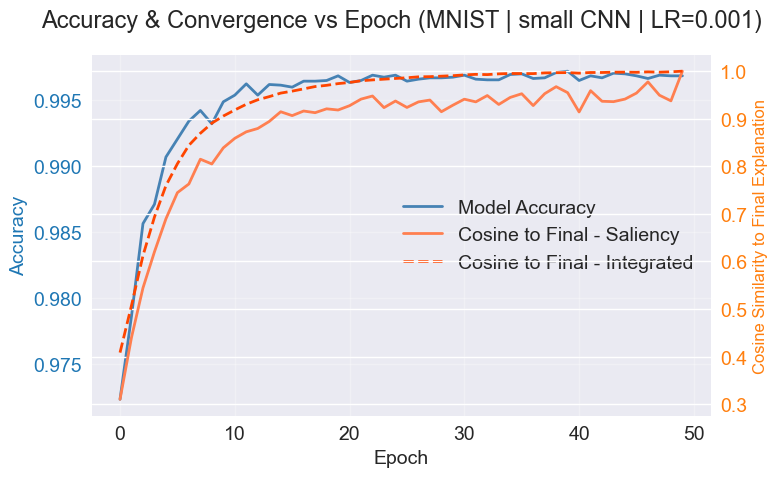

In [216]:
run_accuracy_and_convergence_plot(
    runs,
    dataset="mnist",
    model="small",
    lr=0.001,
    save_dir="plots"
)

In [217]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_vs_stability_single(
    vanilla_agg,
    integrated_agg,
    vanilla_conv,
    integrated_conv,
    dataset,
    model,
    lr,
    save_path=None
):
    T = min(
        len(vanilla_agg["acc_mean"]),
        len(vanilla_conv["mean"]),
        len(integrated_conv["mean"])
    )

    acc = vanilla_agg["acc_mean"][:T]
    stab_v = vanilla_conv["mean"][:T]
    stab_i = integrated_conv["mean"][:T]

    rho_v = spearmanr(acc, stab_v).correlation
    rho_i = spearmanr(acc, stab_i).correlation

    plt.figure(figsize=(7,6))

    plt.scatter(
        acc, stab_v,
        alpha=0.7, s=60,
        label=f"Saliency (ρ = {rho_v:.2f})"
    )
    plt.scatter(
        acc, stab_i,
        alpha=0.7, s=60,
        label=f"Integrated (ρ = {rho_i:.2f})"
    )

    plt.xlabel("Accuracy")
    plt.ylabel("Cosine Similarity to Final Explanation")
    plt.title(
        f"Accuracy vs Explanation Stability\n"
        f"({dataset.upper()} | {model} CNN | LR={lr})"
    )

    plt.legend()
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()
    
def run_accuracy_vs_stability_plot(
    runs,
    dataset,
    model,
    lr,
    save_dir=None
):
    """
    Runs Plot: Accuracy vs Explanation Stability (convergence to final epoch)
    for a fixed dataset, model, and learning rate.
    """

    vanilla_runs = filter_runs(runs, dataset, model, lr, "vanilla")
    integrated_runs = filter_runs(runs, dataset, model, lr, "integrated")

    vanilla_agg = safe_aggregate(vanilla_runs, "vanilla")
    integrated_agg = safe_aggregate(integrated_runs, "integrated")

    # Compute convergence to final explanation
    vanilla_conv = aggregate_cosine_to_final(vanilla_runs)
    integrated_conv = aggregate_cosine_to_final(integrated_runs)

    save_path = (
        f"{save_dir}/accuracy_vs_stability_{dataset}_{model}_lr{lr}.png"
        if save_dir else None
    )
    plot_accuracy_vs_stability_single(
        vanilla_agg,
        integrated_agg,
        vanilla_conv,
        integrated_conv,
        dataset=dataset,
        model=model,
        lr=lr,
        save_path=save_path
    )

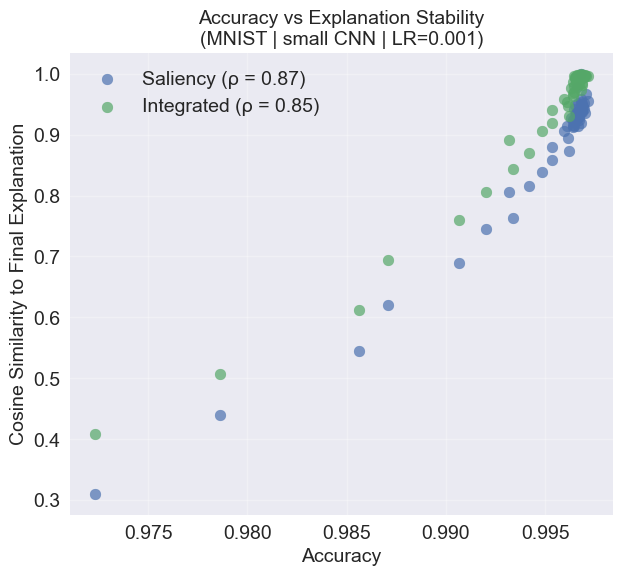

In [218]:
run_accuracy_vs_stability_plot(
    runs,
    dataset="mnist",
    model="small",
    lr=0.001,
    save_dir="plots"
)


## Dataset Effect

In [219]:
def plot_dataset_effect(
    mnist_vanilla,
    mnist_integrated,
    cifar_vanilla,
    cifar_integrated,
    title,
    save_path=None
):
    epochs = np.arange(len(mnist_vanilla["cos_mean"]))

    plt.figure(figsize=(8, 6))

    def plot_with_ci(mean, std, label):
        lower = np.clip(mean - std, 0.0, 1.0)
        upper = np.clip(mean + std, 0.0, 1.0)
        plt.plot(epochs, mean, label=label)
        plt.fill_between(epochs, lower, upper, alpha=0.15)

    plot_with_ci(
        mnist_vanilla["cos_mean"],
        mnist_vanilla["cos_std"],
        "MNIST - Saliency"
    )
    plot_with_ci(
        mnist_integrated["cos_mean"],
        mnist_integrated["cos_std"],
        "MNIST - Integrated"
    )
    plot_with_ci(
        cifar_vanilla["cos_mean"],
        cifar_vanilla["cos_std"],
        "CIFAR - Saliency"
    )
    plot_with_ci(
        cifar_integrated["cos_mean"],
        cifar_integrated["cos_std"],
        "CIFAR - Integrated"
    )

    plt.xlabel("Epoch")
    plt.ylabel("Cosine Similarity (t, t+1)")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

In [220]:
def run_dataset_effect_plot(
    runs,
    model,
    lr,
    save_dir=None
):
    """
    Runs Plot on the Dataset effect on explanation stability
    (MNIST vs CIFAR) for a fixed model and learning rate.
    """

    # Aggregate MNIST
    mnist_vanilla = safe_aggregate(
        filter_runs(runs, "mnist", model, lr, "vanilla"),
        "MNIST vanilla"
    )

    mnist_integrated = safe_aggregate(
        filter_runs(runs, "mnist", model, lr, "integrated"),
        "MNIST integrated"
    )

    # Aggregate CIFAR
    cifar_vanilla = safe_aggregate(
        filter_runs(runs, "cifar", model, lr, "vanilla"),
        "CIFAR vanilla"
    )

    cifar_integrated = safe_aggregate(
        filter_runs(runs, "cifar", model, lr, "integrated"),
        "CIFAR integrated"
    )

    title = (
        f"Dataset Effect on Explanation Stability "
        f"({model.capitalize()} CNN | LR={lr})"
    )

    plot_dataset_effect(
        mnist_vanilla,
        mnist_integrated,
        cifar_vanilla,
        cifar_integrated,
        title=title,
        save_path=(
            f"{save_dir}/dataset_effect_{model}_lr{lr}.png"
            if save_dir else None
        )
    )


### Small CNN

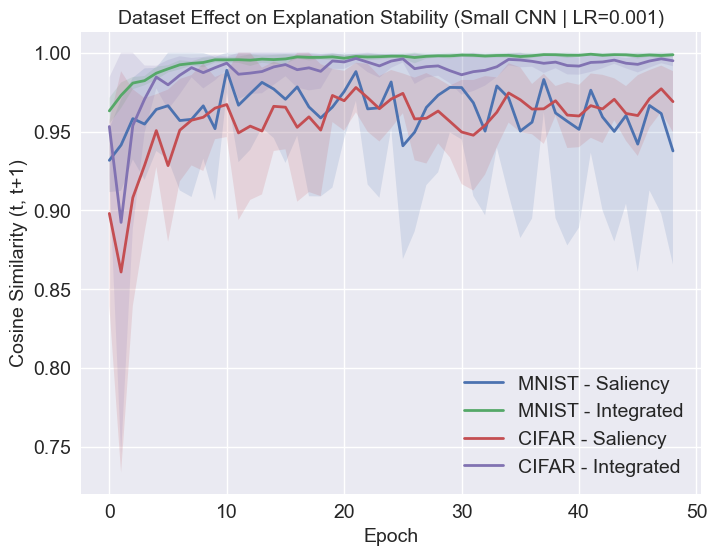

In [221]:
run_dataset_effect_plot(
    runs,
    model="small",
    lr=0.001,
    save_dir="plots"
)


### Deep CNN

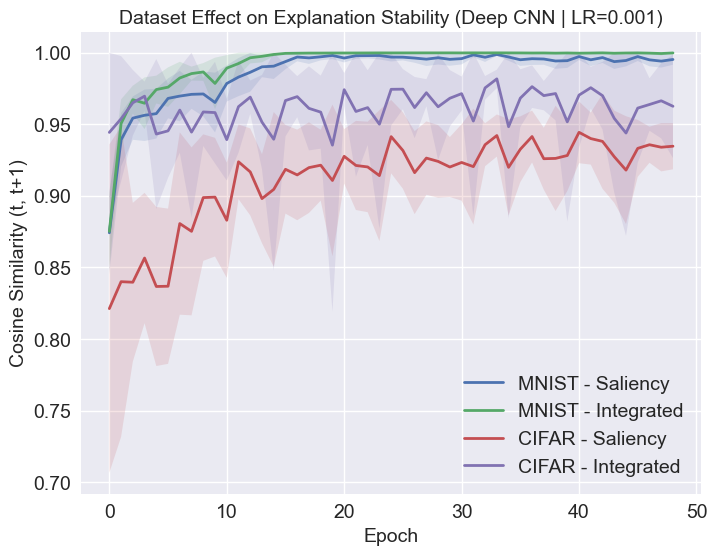

In [222]:
run_dataset_effect_plot(
    runs,
    model="deep",
    lr=0.001,
    save_dir="plots"
)


## Model Size Effect

=== Generating Scatter Plot (Averaged over LR) ===
Plotting 8 averaged configurations
CIFAR - Integrated - Deep: acc=0.680, cos=0.942, var=0.000007
CIFAR - Vanilla - Deep: acc=0.680, cos=0.888, var=0.000100
CIFAR - Integrated - Small: acc=0.582, cos=0.979, var=0.000000
CIFAR - Vanilla - Small: acc=0.582, cos=0.925, var=0.000001
MNIST - Integrated - Deep: acc=0.998, cos=1.000, var=0.005345
MNIST - Vanilla - Deep: acc=0.998, cos=0.986, var=0.066015
MNIST - Integrated - Small: acc=0.997, cos=0.999, var=0.002236
MNIST - Vanilla - Small: acc=0.997, cos=0.961, var=0.034997
Saved plot to plots/scatter_accuracy_vs_stability_averaged.png


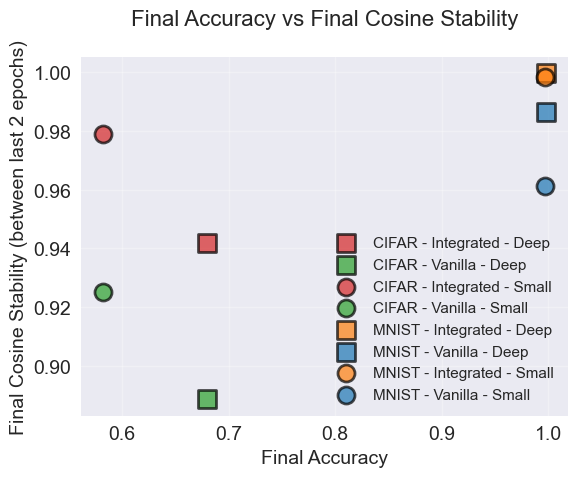


✓ Scatter plot generated!


In [223]:
# Scatter plot
def create_scatter_plot_averaged(runs, save_path=None, dpi=300):
    """
    Create scatter plot with metrics averaged over learning rates
    8 points total (2 datasets x 2 models x 2 methods)
    """
    metrics = average_metrics_over_lr(runs)
    
    print(f"Plotting {len(metrics)} averaged configurations")
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    color_map = {
        ("mnist", "vanilla"): "#1f77b4",
        ("mnist", "integrated"): "#ff7f0e",
        ("cifar", "vanilla"): "#2ca02c",
        ("cifar", "integrated"): "#d62728"
    }
    

    marker_map = {
        "small": "o",
        "deep": "s"
    }
    
    size = 150
    
    # Plot each configuration
    for m in metrics:
        color_key = (m["dataset"], m["method"])
        color = color_map[color_key]
        marker = marker_map[m["model"]]
        
        label = f"{m['dataset'].upper()} - {m['method'].title()} - {m['model'].capitalize()}"
        
        ax.scatter(
            m["final_accuracy"],
            m["final_cosine"],
            c=color,
            marker=marker,
            s=size,
            alpha=0.7,
            edgecolors='black',
            linewidth=2,
            label=label
        )
        
        print(f"{label}: acc={m['final_accuracy']:.3f}, cos={m['final_cosine']:.3f}, var={m['variance']:.6f}")
    
    ax.set_xlabel("Final Accuracy", fontsize=14)
    ax.set_ylabel("Final Cosine Stability (between last 2 epochs)", fontsize=14)
    ax.set_title("Final Accuracy vs Final Cosine Stability\n", fontsize=16)
    ax.grid(True, alpha=0.3)
    
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    
    plt.tight_layout()
    
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
        print(f"Saved plot to {save_path}")
    
    plt.show()


print("=== Generating Scatter Plot (Averaged over LR) ===")
create_scatter_plot_averaged(
    runs,
    save_path="plots/scatter_accuracy_vs_stability_averaged.png"
)
print("\n✓ Scatter plot generated!")

In [224]:
def plot_model_effect(
    small_vanilla,
    small_integrated,
    deep_vanilla,
    deep_integrated,
    title,
    save_path=None
):
    epochs = np.arange(len(small_vanilla["cos_mean"]))

    plt.figure(figsize=(8, 6))

    def plot_with_ci(mean, std, label):
        lower = np.clip(mean - std, 0.0, 1.0)
        upper = np.clip(mean + std, 0.0, 1.0)
        plt.plot(epochs, mean, label=label)
        plt.fill_between(epochs, lower, upper, alpha=0.15)

    plot_with_ci(
        small_vanilla["cos_mean"],
        small_vanilla["cos_std"],
        "Small - Saliency"
    )
    plot_with_ci(
        small_integrated["cos_mean"],
        small_integrated["cos_std"],
        "Small - Integrated"
    )
    plot_with_ci(
        deep_vanilla["cos_mean"],
        deep_vanilla["cos_std"],
        "Deep - Saliency"
    )
    plot_with_ci(
        deep_integrated["cos_mean"],
        deep_integrated["cos_std"],
        "Deep - Integrated"
    )

    plt.xlabel("Epoch")
    plt.ylabel("Cosine Similarity (t, t+1)")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


In [225]:
def run_model_effect_plot(
    runs,
    dataset,
    lr,
    save_dir=None
):
    """
    Runs Plot on the Model size effect on explanation stability
    (Small vs Deep) for a fixed dataset and learning rate.
    """

    #Aggregate Small
    small_vanilla = safe_aggregate(
        filter_runs(runs, dataset, "small", lr, "vanilla"),
        "Small vanilla"
    )

    small_integrated = safe_aggregate(
        filter_runs(runs, dataset, "small", lr, "integrated"),
        "Small integrated"
    )

    # Aggregate deep
    deep_vanilla = safe_aggregate(
        filter_runs(runs, dataset, "deep", lr, "vanilla"),
        "Deep vanilla"
    )

    deep_integrated = safe_aggregate(
        filter_runs(runs, dataset, "deep", lr, "integrated"),
        "Deep integrated"
    )

    title = (
        f"Model Size Effect on Explanation Stability "
        f"({dataset.upper()} | LR={lr})"
    )

    plot_model_effect(
        small_vanilla,
        small_integrated,
        deep_vanilla,
        deep_integrated,
        title=title,
        save_path=(
            f"{save_dir}/model_effect_{dataset}_lr{lr}.png"
            if save_dir else None
        )
    )


### MNIST

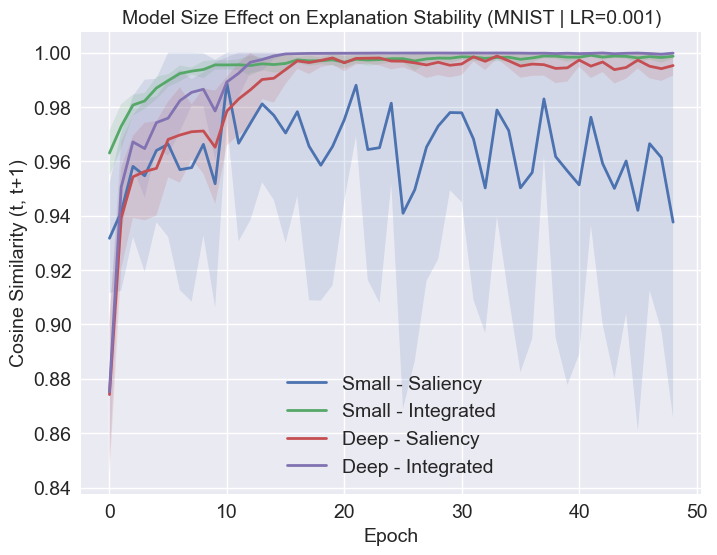

In [226]:
run_model_effect_plot(
    runs,
    dataset="mnist",
    lr=0.001,
    save_dir="plots"
)

### CIFAR

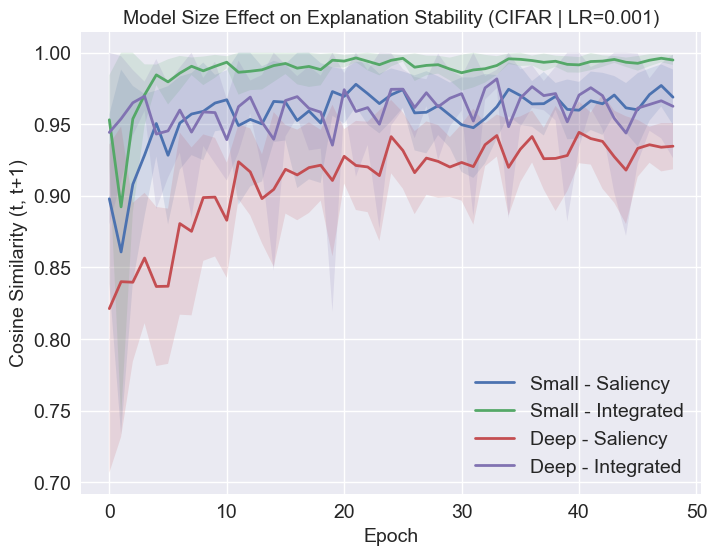

In [227]:
run_model_effect_plot(
    runs,
    dataset="cifar",
    lr=0.001,
    save_dir="plots"
)

# Learning rate effect

In [228]:
def plot_learning_rate_effect(
    low_lr_vanilla,
    low_lr_integrated,
    high_lr_vanilla,
    high_lr_integrated,
    title,
    save_path=None
):
    epochs = np.arange(len(low_lr_vanilla["cos_mean"]))

    plt.figure(figsize=(8, 6))

    def plot_with_ci(mean, std, label):
        lower = np.clip(mean - std, 0.0, 1.0)
        upper = np.clip(mean + std, 0.0, 1.0)
        plt.plot(epochs, mean, label=label)
        plt.fill_between(epochs, lower, upper, alpha=0.15)

    #Low LR
    plot_with_ci(
        low_lr_vanilla["cos_mean"],
        low_lr_vanilla["cos_std"],
        "LR=0.001 - Saliency"
    )
    plot_with_ci(
        low_lr_integrated["cos_mean"],
        low_lr_integrated["cos_std"],
        "LR=0.001 - Integrated"
    )

    #High LR
    plot_with_ci(
        high_lr_vanilla["cos_mean"],
        high_lr_vanilla["cos_std"],
        "LR=0.01 - Saliency"
    )
    plot_with_ci(
        high_lr_integrated["cos_mean"],
        high_lr_integrated["cos_std"],
        "LR=0.01 - Integrated"
    )

    plt.xlabel("Epoch")
    plt.ylabel("Cosine Similarity (t, t+1)")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


In [229]:
def run_learning_rate_effect_plot(
    runs,
    dataset,
    model,
    lr_low=0.001,
    lr_high=0.01,
    save_dir=None
):
    """
    Runs Learning Rate Effect plot:
    Compares explanation stability for two learning rates.
    """

    # Low LR
    low_lr_vanilla = safe_aggregate(
        filter_runs(runs, dataset, model, lr_low, "vanilla"),
        f"{dataset}-{model}-lr{lr_low}-vanilla"
    )
    low_lr_integrated = safe_aggregate(
        filter_runs(runs, dataset, model, lr_low, "integrated"),
        f"{dataset}-{model}-lr{lr_low}-integrated"
    )

    # High LR
    high_lr_vanilla = safe_aggregate(
        filter_runs(runs, dataset, model, lr_high, "vanilla"),
        f"{dataset}-{model}-lr{lr_high}-vanilla"
    )
    high_lr_integrated = safe_aggregate(
        filter_runs(runs, dataset, model, lr_high, "integrated"),
        f"{dataset}-{model}-lr{lr_high}-integrated"
    )

    title = (
        f"Learning Rate Effect on Explanation Stability "
        f"({dataset.upper()} | {model.capitalize()} CNN)"
    )

    plot_learning_rate_effect(
        low_lr_vanilla,
        low_lr_integrated,
        high_lr_vanilla,
        high_lr_integrated,
        title=title,
        save_path=(
            f"{save_dir}/lr_effect_{dataset}_{model}.png"
            if save_dir else None
        )
    )


### MNIST; Small CNN

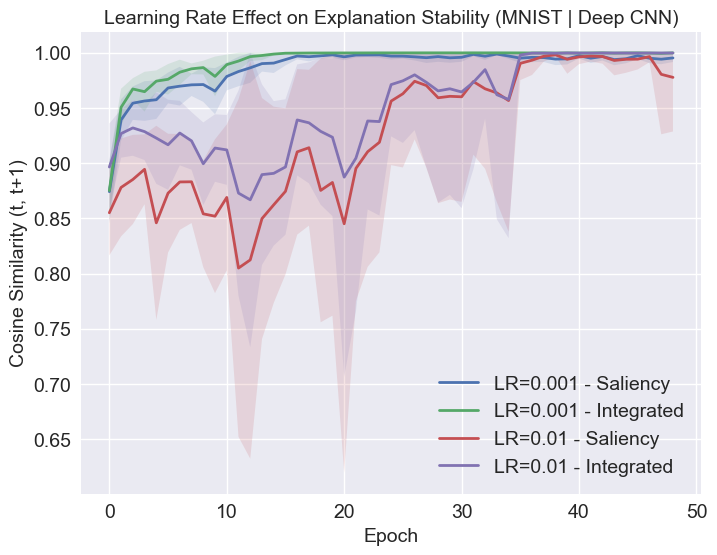

In [230]:
run_learning_rate_effect_plot(
    runs,
    dataset="mnist",
    model="deep",
    save_dir="plots"
)


### Cifar; Deep CNN

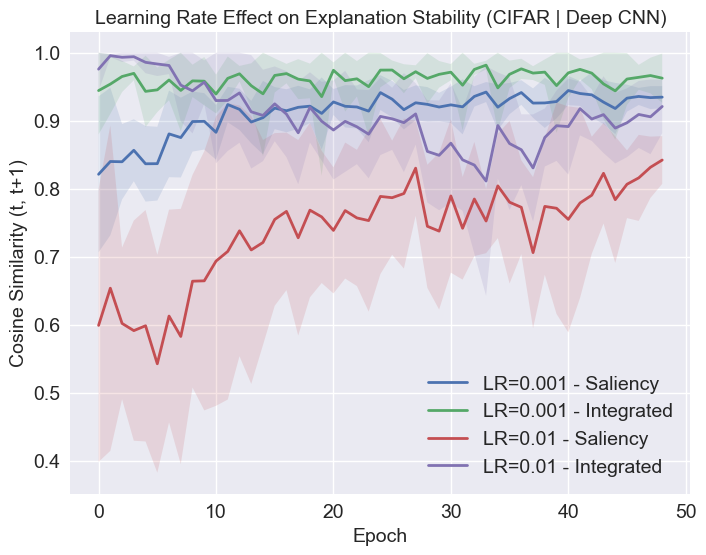

In [231]:
run_learning_rate_effect_plot(
    runs,
    dataset="cifar",
    model="deep",
    save_dir="plots"
)

## Explanation Variance

In [232]:
def plot_variance_bar(vanilla, integrated, title, save_path=None):
    means = [vanilla["var_mean"], integrated["var_mean"]]
    stds = [vanilla["var_std"], integrated["var_std"]]

    plt.figure(figsize=(5, 4))
    plt.bar(
        ["Saliency", "Integrated"],
        means,
        yerr=stds,
        capsize=5
    )

    plt.ylabel("Explanation Variance")
    plt.title(title)
    plt.grid(axis="y")

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [233]:
def run_variance_plot(
    runs,
    dataset,
    model,
    lr,
    save_dir=None
):
    """
    Runs Plot on Explanation variance comparison
    (Saliency vs Integrated Gradients) for a given configuration.
    """

    vanilla_runs = filter_runs(
        runs, dataset, model, lr, "vanilla"
    )
    integrated_runs = filter_runs(
        runs, dataset, model, lr, "integrated"
    )

    vanilla_agg = safe_aggregate(
        vanilla_runs,
        f"{dataset}-{model}-vanilla"
    )
    integrated_agg = safe_aggregate(
        integrated_runs,
        f"{dataset}-{model}-integrated"
    )

    title = (
        f"Explanation Variance Comparison "
        f"({dataset.upper()} | {model.capitalize()} CNN | LR={lr})"
    )

    plot_variance_bar(
        vanilla_agg,
        integrated_agg,
        title=title,
        save_path=(
            f"{save_dir}/variance_{dataset}_{model}_lr{lr}.png"
            if save_dir else None
        )
    )


### MNIST; Small CNN

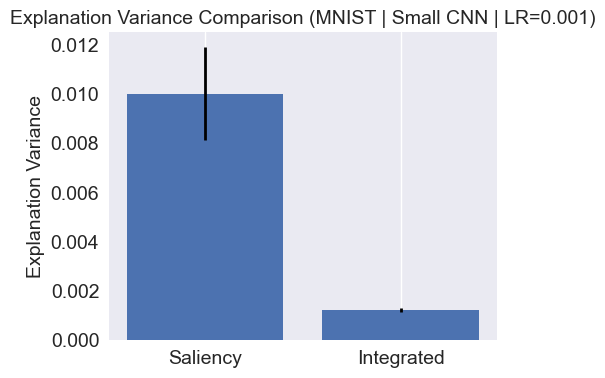

In [234]:
run_variance_plot(
    runs,
    dataset="mnist",
    model="small",
    lr=0.001,
    save_dir="plots"
)

### CIFAR; Deep CNN

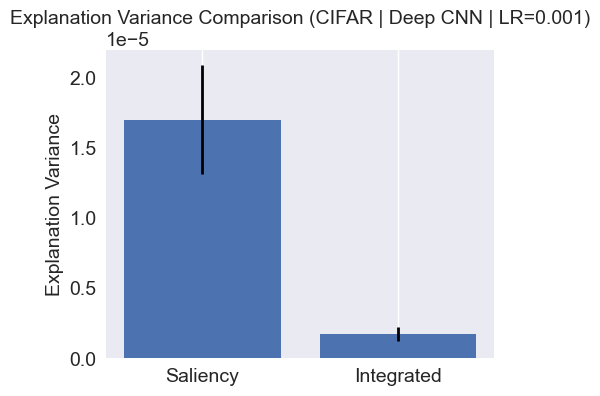

In [235]:
run_variance_plot(
    runs,
    dataset="cifar",
    model="deep",
    lr=0.001, 
    save_dir="plots"
)